# Sequence-to-sequence activity recognition

In [1]:
from tensorflow.keras.layers import (
    Add,
    Dense,
    Dropout,
    MultiHeadAttention,
    LayerNormalization,
    Layer,
    Normalization,
)
from tensorflow.keras import Model
from tensorflow.keras.initializers import TruncatedNormal
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


## Layer

In [2]:
class PositionalEmbedding(Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.units = units

        self.projection = Dense(units, kernel_initializer=TruncatedNormal(stddev=0.02))

        self.dropout = Dropout(rate=dropout_rate)

    def build(self, input_shape):
        super(PositionalEmbedding, self).build(input_shape)

        self.position = self.add_weight(
            name="position",
            shape=(1, input_shape[1], self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, inputs, training):
        x = self.projection(inputs)
        x = x + self.position

        return self.dropout(x, training=training)


In [3]:
class Encoder(Layer):
    def __init__(
        self,
        embed_dim,
        mlp_dim,
        num_heads,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(Encoder, self).__init__(**kwargs)

        self.mha = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )

        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-5)
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        self.add_0 = Add()
        self.add_1 = Add()

    def call(self, inputs, training):
        # Attention block
        x = self.norm_0(inputs)
        x, attn = self.mha(
            query=x,
            value=x,
            key=x,
            return_attention_scores=True,
            training=training,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # MLP block
        y = self.norm_1(x)
        y = self.dense_0(y)
        y = self.dense_1(y)
        y = self.dropout_1(y, training=training)

        return self.add_1([x, y]), attn


## Model

In [4]:
class Transformer(Model):
    def __init__(
        self,
        num_layers,
        embed_dim,
        mlp_dim,
        num_heads,
        num_classes,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(Transformer, self).__init__(**kwargs)

        # Input (normalization of RAW measurements)
        self.input_norm = Normalization()

        # Input
        self.pos_embs = PositionalEmbedding(embed_dim, dropout_rate)

        # Encoder
        self.e_layers = [
            Encoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_layers)
        ]

        # Output
        self.norm = LayerNormalization(epsilon=1e-5)
        self.final_layer = Dense(num_classes, kernel_initializer="zeros")

    def call(self, inputs, training):
        x = self.input_norm(inputs)
        x = self.pos_embs(x, training=training)

        for layer in self.e_layers:
            x, attn = layer(x, training=training)

        x = self.norm(x)
        x = self.final_layer(x)

        return x, attn


## Dataset

In [5]:
CLASS_LABELS = np.array(
    [
        "Stand",
        "Sit",
        "Talk-sit",
        "Talk-stand",
        "Stand-sit",
        "Lay",
        "Lay-stand",
        "Pick",
        "Jump",
        "Push-up",
        "Sit-up",
        "Walk",
        "Walk-backward",
        "Walk-circle",
        "Run",
        "Stair-up",
        "Stair-down",
        "Table-tennis",
    ]
)

# load dataset
f = np.load("./dataset/new_dataset.npz")
signals = f["signals"]
labels = f["labels"]

# split to train-test
X_train, X_test, y_train, y_test = train_test_split(
    signals, labels, test_size=0.15, random_state=9, stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=9, stratify=y_train
)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)


(60060, 300, 6) (60060, 300)
(12470, 300, 6) (12470, 300)
(10599, 300, 6) (10599, 300)


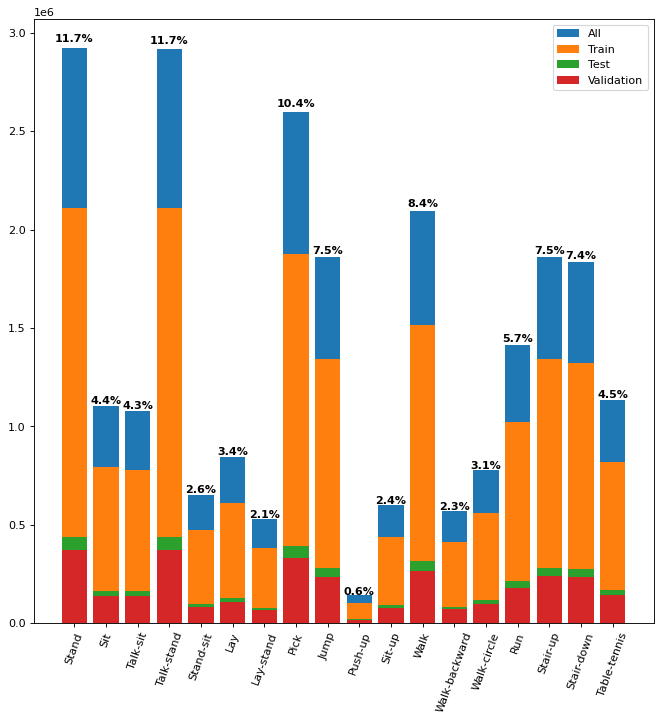

In [6]:
plt.figure(figsize=(10, 10), dpi=80)

total_counts = labels.shape[0] * labels.shape[1]
unique, all_counts = np.unique(labels, return_counts=True)
chart = plt.bar(CLASS_LABELS[unique], all_counts)
plt.xticks(rotation=70)

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

unique, counts = np.unique(y_test, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

unique, counts = np.unique(y_val, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

for i, p in enumerate(chart):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(
        x + width / 2,
        y + height * 1.01,
        str(round((all_counts[i] * 100) / total_counts, 1)) + "%",
        ha="center",
        weight="bold",
    )

plt.legend(["All", "Train", "Test", "Validation"])
plt.show()


## Create model

In [7]:
# Generate new model
model = Transformer(
    num_layers=3,
    embed_dim=128,
    mlp_dim=256,
    num_heads=6,
    num_classes=18,
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-11 14:18:49.046236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-11 14:18:49.046505: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(1, 300, 18) (1, 6, 300, 300)


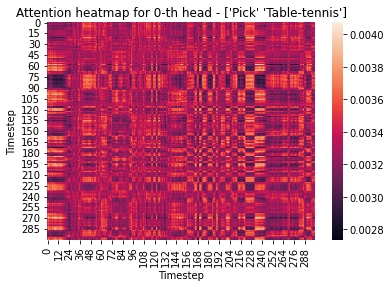

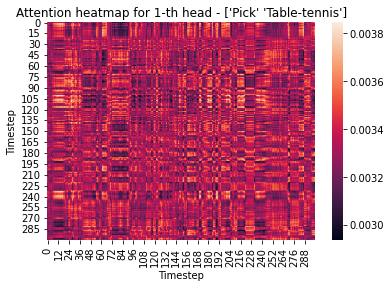

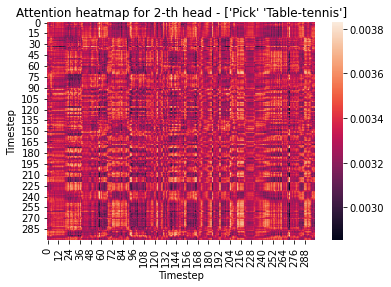

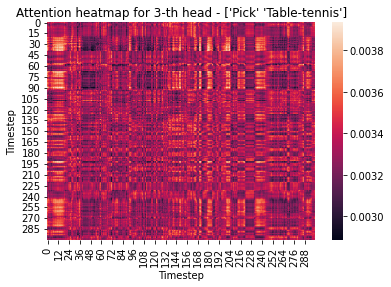

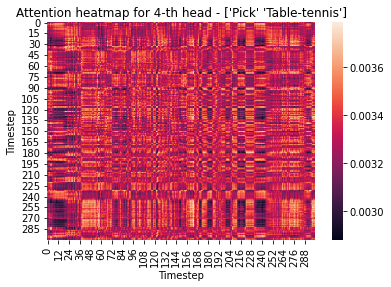

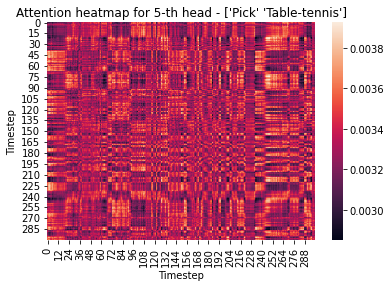

In [8]:
batch_id = 20

out, attn = model(tf.expand_dims(X_test[batch_id], axis=0))
print(out.shape, attn.shape)

for i in range(attn.shape[1]):
    plt.figure()
    ax = sns.heatmap(attn[0, i])
    ax.set_title(
        f"Attention heatmap for {i}-th head - {CLASS_LABELS[np.unique(y_test[batch_id])]}"
    )
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Timestep")



## Visualize position

Text(33.0, 0.5, 'Timestep')

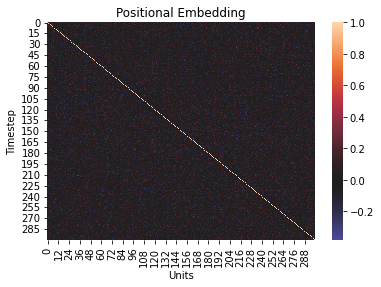

In [9]:
similarity_scores = np.dot(
    model.pos_embs.position[0], np.transpose(model.pos_embs.position[0])
) / (
    np.linalg.norm(model.pos_embs.position[0], axis=-1)
    * np.linalg.norm(model.pos_embs.position[0], axis=-1)
)


plt.figure()
ax = sns.heatmap(similarity_scores, center=0)
ax.set_title("Positional Embedding")
ax.set_xlabel("Units")
ax.set_ylabel("Timestep")


In [10]:
model.summary()


Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 13        
 n)                                                              
                                                                 
 positional_embedding (Posit  multiple                 39296     
 ionalEmbedding)                                                 
                                                                 
 encoder (Encoder)           multiple                  462080    
                                                                 
 encoder_1 (Encoder)         multiple                  462080    
                                                                 
 encoder_2 (Encoder)         multiple                  462080    
                                                                 
 layer_normalization_6 (Laye  multiple                 

## Load trained model

In [11]:
model.load_weights("./save/model-best.h5")


(1, 300, 18) (1, 6, 300, 300)


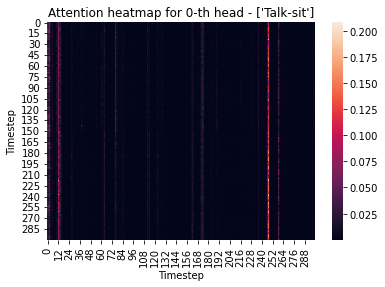

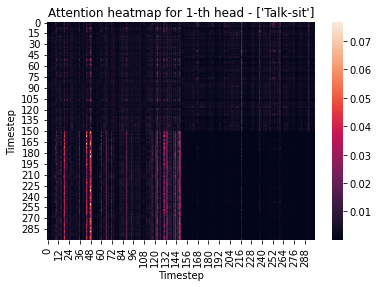

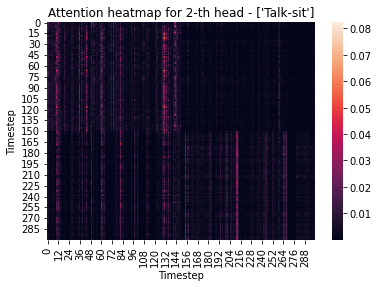

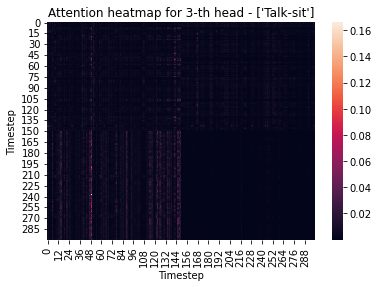

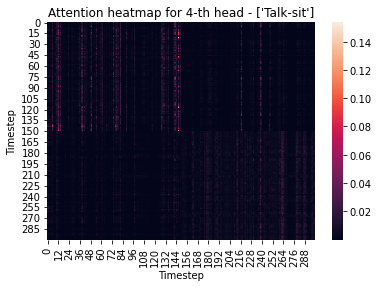

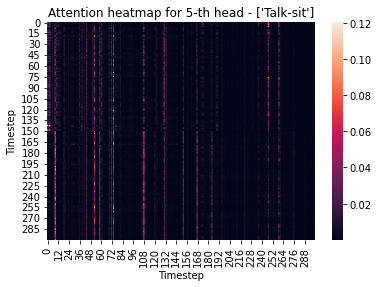

In [12]:
batch_id = 75

out, attn = model(tf.expand_dims(X_test[batch_id], axis=0))
print(out.shape, attn.shape)

for i in range(attn.shape[1]):
    plt.figure()
    ax = sns.heatmap(attn[0, i])
    ax.set_title(
        f"Attention heatmap for {i}-th head - {CLASS_LABELS[np.unique(y_test[batch_id])]}"
    )
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Timestep")


## Visualize position

Text(33.0, 0.5, 'Timestep')

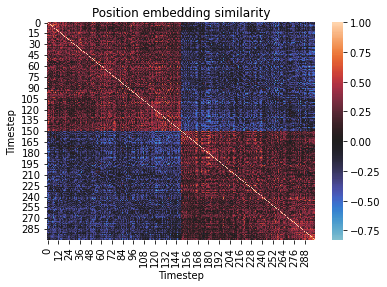

In [13]:
similarity_scores = np.dot(
    model.pos_embs.position[0], np.transpose(model.pos_embs.position[0])
) / (
    np.linalg.norm(model.pos_embs.position[0], axis=-1)
    * np.linalg.norm(model.pos_embs.position[0], axis=-1)
)


plt.figure()
ax = sns.heatmap(similarity_scores, center=0)
ax.set_title("Position embedding similarity")
ax.set_xlabel("Timestep")
ax.set_ylabel("Timestep")


In [14]:
def get_predictions(start, end):
    out, attn = model(X_test[start:end])
    predictions = np.argmax(out, axis=-1)

    return predictions, attn


batch_size = 256  # set it by your GPU size

full_predictions = []
for i in range(X_test.shape[0] // batch_size):
    y, _ = get_predictions(i * batch_size, (i + 1) * batch_size)
    full_predictions.append(y)

y, attn = get_predictions((i + 1) * batch_size, X_test.shape[0])
full_predictions.append(y)

full_predictions = np.concatenate(full_predictions, axis=0)
print(full_predictions.shape)

full_predictions = full_predictions.reshape(-1, full_predictions.shape[-1])
print(full_predictions.shape)


(12470, 300)
(12470, 300)


## Confusion Matrix

               precision    recall  f1-score   support

        Stand      0.990     0.988     0.989    438600
          Sit      0.961     0.942     0.951    165000
     Talk-sit      0.945     0.970     0.957    161400
   Talk-stand      0.994     0.999     0.996    437700
    Stand-sit      0.986     0.992     0.989     98100
          Lay      0.978     0.986     0.982    126900
    Lay-stand      0.988     0.985     0.987     79200
         Pick      0.999     0.997     0.998    389700
         Jump      1.000     0.999     0.999    279000
      Push-up      0.995     0.997     0.996     21600
       Sit-up      0.994     0.982     0.988     90600
         Walk      0.999     0.997     0.998    314400
Walk-backward      0.998     0.994     0.996     84600
  Walk-circle      0.995     0.999     0.997    117000
          Run      0.998     0.999     0.998    212400
     Stair-up      0.998     0.997     0.998    279300
   Stair-down      0.999     0.996     0.997    274800
 Table-te

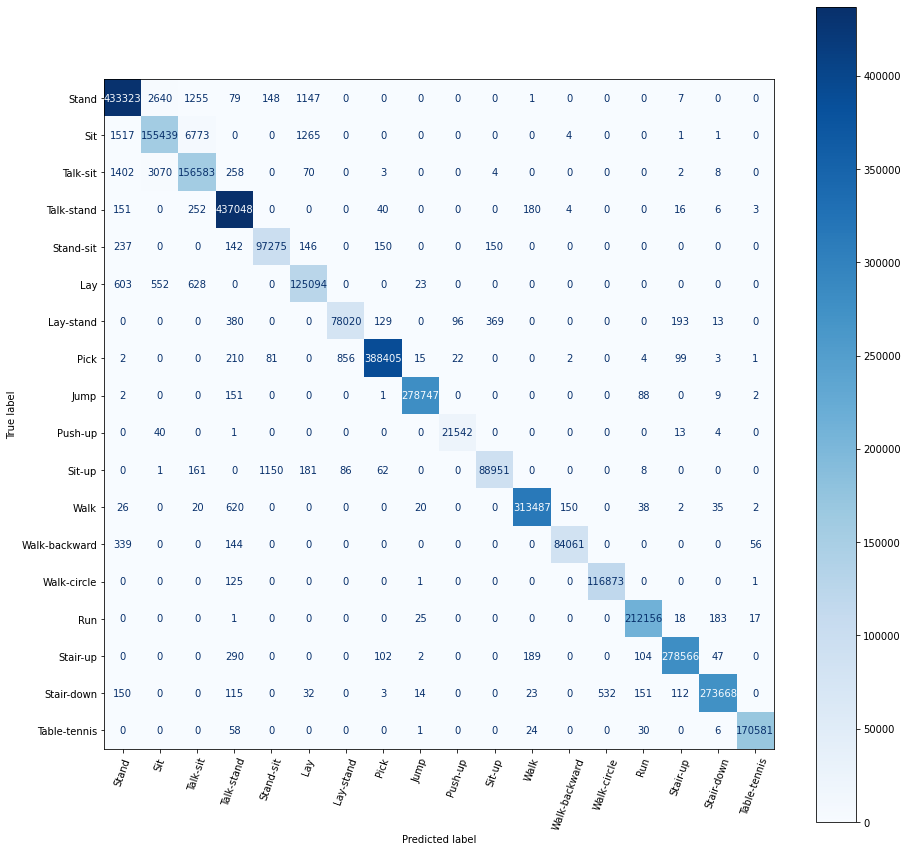

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(
    CLASS_LABELS[y_test.reshape(-1)],
    CLASS_LABELS[full_predictions.reshape(-1)],
    labels=CLASS_LABELS,
)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=CLASS_LABELS
).plot(cmap="Blues", xticks_rotation=70, ax=ax)

print(
    classification_report(
        CLASS_LABELS[y_test.reshape(-1)],
        CLASS_LABELS[full_predictions.reshape(-1)],
        labels=CLASS_LABELS,
        digits=3,
    )
)


## Profiler

In [16]:
@tf.function
def xy():
    out, attn = model(X_test[0])

# You can also do that in Python API.
tf.compat.v1.profiler.profile(
    xy.get_concrete_function().graph,
    options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number

name: "_TFProfRoot"
children {
  name: "transformer/encoder/dense_1/Tensordot/MatMul"
  float_ops: 19660800
  total_float_ops: 19660800
  input_shapes {
    value {
      dim {
        size: 300
      }
      dim {
        size: 128
      }
    }
  }
  input_shapes {
    key: 1
    value {
      dim {
        size: 128
      }
      dim {
        size: 256
      }
    }
  }
  total_definition_count: 1
}
children {
  name: "transformer/encoder/dense_2/Tensordot/MatMul"
  float_ops: 19660800
  total_float_ops: 19660800
  input_shapes {
    value {
      dim {
        size: 300
      }
      dim {
        size: 256
      }
    }
  }
  input_shapes {
    key: 1
    value {
      dim {
        size: 256
      }
      dim {
        size: 128
      }
    }
  }
  total_definition_count: 1
}
children {
  name: "transformer/encoder_1/dense_3/Tensordot/MatMul"
  float_ops: 19660800
  total_float_ops: 19660800
  input_shapes {
    value {
      dim {
        size: 300
      }
      dim {
        s